In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [3]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.1)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_neg_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [('-', inp), '=']
        trial.append(-1*cue_dict[inp])
        seq.append(trial)
    return seq

def generate_2step_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=2))
    combi_operators = list(itertools.product(ops, repeat=2))
    for init in init_values:
        for cues in combi_inputcue:
            for operators in combi_operators:
                seq.append([init,
                            *zip(tuple(operators), cues), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_1step_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    combi_operators = list(itertools.product(ops, repeat=1))
    for init in init_values:
        for cues in combi_inputcue:
            for operators in combi_operators:
                seq.append([init,
                            *zip(tuple(operators), cues), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def plot_accs(acc_arrays, labels, colors, title, shift = 0):

    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        plt.plot(x, mn, label = labels[i], color = colors[i])
        plt.fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.title(title, fontsize=10)

    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


# RNN setup

In [4]:
## running function

def run_exp(trainseqs_old, testseqs_old1, testseqs_old2, cue_dict):
 
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset1, testset2], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test1': testset1, 'test2': testset2}

def run_plot(trainseqs, testseqs1, testseqs2,cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs1,testseqs2, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test1 = np.array([r['acc'][:,1] for r in res]).T
    acc_test2 = np.array([r['acc'][:,2] for r in res]).T
    mods = [r['mod'] for r in res]
    tests1 = [r['test1'] for r in res]
    tests2 = [r['test2'] for r in res]

    plotNNs([losses], [acc_train, acc_test1, acc_test2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc1': acc_test1[-1,:], 'test_acc2': acc_test2[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc1 = fully_trained['test_acc1'].mean() 
    fully_trained_test_acc_std1 = fully_trained['test_acc1'].std()
    fully_trained_test_acc2 = fully_trained['test_acc2'].mean() 
    fully_trained_test_acc_std2 = fully_trained['test_acc2'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests1 = [tests1[i] for i in fully_trained_idx]
    ft_tests2 = [tests2[i] for i in fully_trained_idx]
    if len(ft_mods) > 0:
        plt.figure()
        r2_1, dfs_1, alldfs_1 = predcorr(ft_mods, ft_tests1, plot_corr = True)
        plt.figure()
        r2_2, dfs_2, alldfs_2 = predcorr(ft_mods, ft_tests2, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0

    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc1, 2), '\n2 step acc: ',round(fully_trained_test_acc2, 2), '\n-----------\n')

    return {'res':res,'mean_acc_final1': fully_trained_test_acc1,'mean_acc_final2': fully_trained_test_acc2, \
            'df_trials1': dfs_1, 'df_trials2': dfs_2,'acc_std1': fully_trained_test_acc_std1,\
           'acc_std2': fully_trained_test_acc_std2, 'ft_mods': ft_mods, 'ft_tests1': ft_tests1, 'ft_tests2': ft_tests2}



In [23]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 8

# Experiments

Final accuracy against ratio of other/self



In [9]:
ops = ['+','-']

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)


{'A': 6, 'B': 10, 'C': 13, 'D': 4}


run time:  25.013997650146486
44
total time:  25.021790766716002
44 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.12 
2 step acc:  0.27 
-----------

                          label       pred       acc
trial                                               
['B', '+', 'D', '=']  18.295455  19.056668  0.159091
['C', '+', 'D', '=']  19.045455  19.508190  0.159091
['D', '+', 'A', '=']  19.113636  17.147164  0.136364
['D', '+', 'B', '=']  18.295455  16.078517  0.113636
['D', '+', 'C', '=']  19.045455  17.092556  0.113636
['A', '+', 'D', '=']  19.113636  19.928377  0.090909
['D', '+', 'D', '=']  19.409091  17.275548  0.068182
                         label      pred       acc
trial                                             
['B', '-', 'D', '='] -1.113636 -2.198269  0.500000
['A', '-', 'D', '='] -0.295455 -1.017261  0.431818
['C', '-', 'D', '='] -0.363636 -1.607776  0.409091
['D', '-', 'B', '=']  1.113636 -0.268604  0.159091
['D', '-', 'A', '=']  0.295455 -1.203814  0.1363

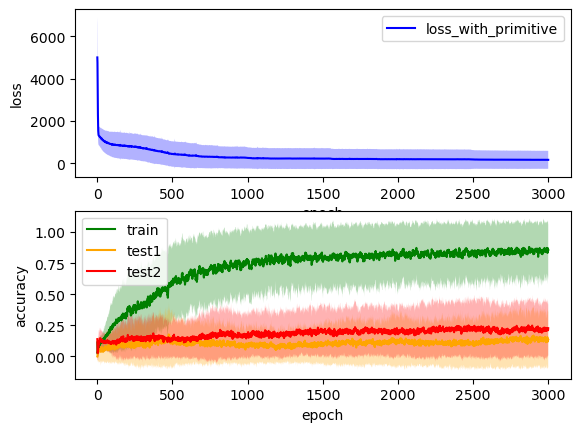

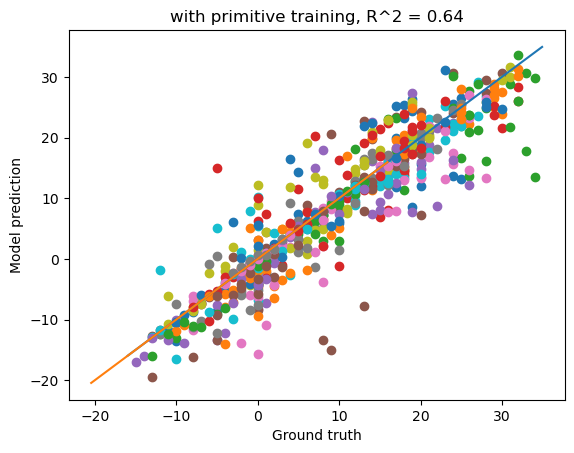

In [37]:
epochs = 3000
num_sims = 80
trainseqs = generate_1step_trials(ops, all_syms[:-1],  all_syms[:-1])+ p + p_neg
testseqs_add = generate_trials('+', all_syms, all_syms)
testseqs_add = [s for s in testseqs_add if s not in trainseqs]
testseqs_sub = generate_trials('-', all_syms, all_syms)
testseqs_sub = [s for s in testseqs_sub if s not in trainseqs]
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict)
print(res1['df_trials1'])
print(res1['df_trials2'])

Text(0.5, 1.0, 'Addition test set (R^2 = 0.42)')

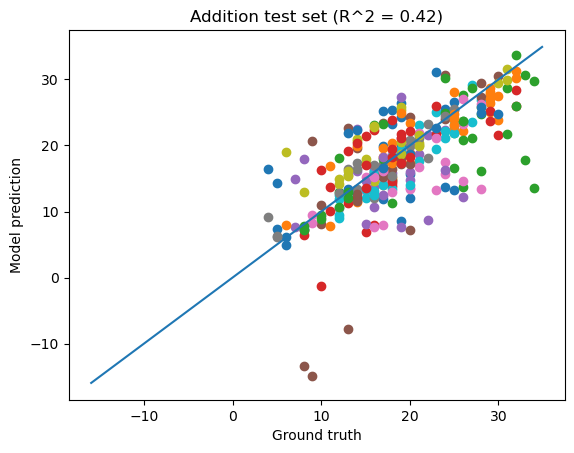

In [44]:
a,b1,c = predcorr(res1['ft_mods'], res1['ft_tests1'], plot_corr = True)
plt.title('Addition test set (R^2 = 0.42)')

Text(0.5, 1.0, 'Subtraction test set (R^2 = 0.64)')

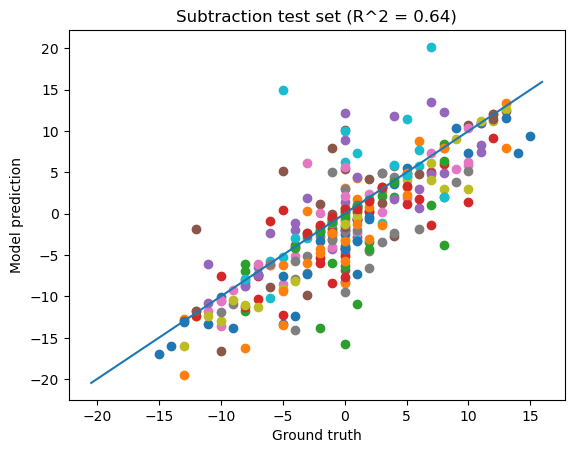

In [45]:
a,b2,c = predcorr(res1['ft_mods'], res1['ft_tests2'], plot_corr = True)
plt.title('Subtraction test set (R^2 = 0.64)')

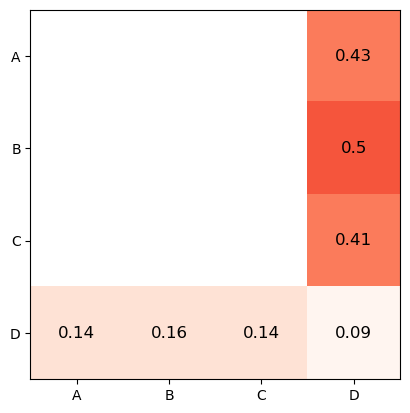

In [48]:
num_cols = 1
dfs = [b1, b2]
fig, axs = plt.subplots(1,1)
heatmap_acc(num_inputs, b2, axs)

run time:  1.8246925314267477
2
total time:  1.826509745915731
2 / 8  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
2 step acc:  0.0 
-----------

                      label       pred  acc
trial                                      
['B', '+', 'D', '=']   15.5  14.737666  0.5
['D', '+', 'B', '=']   15.5  10.006595  0.5
['A', '+', 'D', '=']   18.5  17.924103  0.0
['C', '+', 'D', '=']   15.0  14.466840  0.0
['D', '+', 'A', '=']   18.5  13.692416  0.0
['D', '+', 'C', '=']   15.0  11.144653  0.0
['D', '+', 'D', '=']   23.0  12.877646  0.0
                      label      pred  acc
trial                                     
['A', '-', 'D', '=']   -4.5 -4.484167  0.0
['B', '-', 'D', '=']   -7.5 -6.806679  0.0
['C', '-', 'D', '=']   -8.0 -8.192338  0.0
['D', '-', 'A', '=']    4.5  0.501324  0.0
['D', '-', 'B', '=']    7.5  3.372229  0.0
['D', '-', 'C', '=']    8.0  4.208899  0.0
['D', '-', 'D', '=']    0.0 -4.835002  0.0


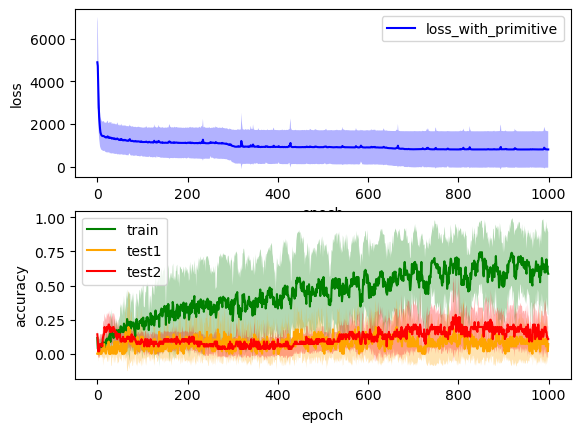

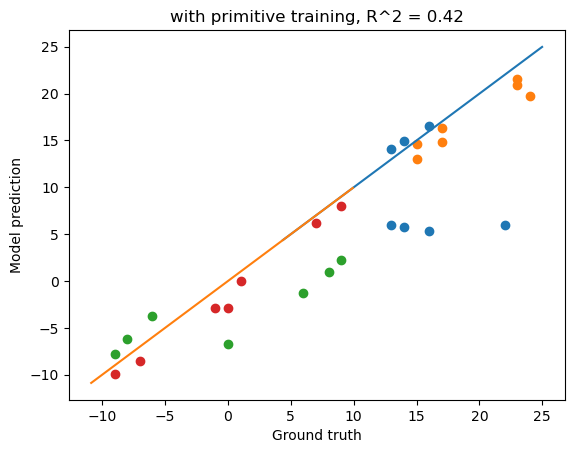

In [32]:
trainseqs = generate_1step_trials(ops, all_syms[:-1],  all_syms[:-1])+ p + p_neg
testseqs_add = generate_trials('+', all_syms, all_syms)
testseqs_add = [s for s in testseqs_add if s not in trainseqs]
testseqs_sub = generate_trials('-', all_syms, all_syms)
testseqs_sub = [s for s in testseqs_sub if s not in trainseqs]
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict)
print(res1['df_trials1'])
print(res1['df_trials2'])

In [30]:
trainseqs = generate_1step_trials(ops, all_syms[:-1],  all_syms[:-1])+ p
testseqs_add = generate_trials('+', all_syms, all_syms)
testseqs_add = [s for s in testseqs_add if s not in trainseqs]
testseqs_sub = generate_trials('-', all_syms, all_syms)
testseqs_sub = [s for s in testseqs_sub if s not in trainseqs]
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict)
print(res1['df_trials1'])
print(res1['df_trials2'])

ValueError: num_samples should be a positive integer value, but got num_samples=0